      hour_of_day  pressure  air_temp  ground_temp  windspeed    x    y  \
0               0    0.9954   -0.0001      -0.0017     0.0678  318  132   
1               1    1.0068   -0.0006      -0.0042     0.0935  318  132   
2               2    1.0194   -0.0013      -0.0056     0.0998  318  132   
3               3    1.0434   -0.0012      -0.0040     0.1071  318  132   
4               4    1.0848   -0.0010      -0.0026     0.0995  318  132   
...           ...       ...       ...          ...        ...  ...  ...   
2251           19    0.6320   -0.0004      -0.0003     0.1476  318  132   
2252           20    0.6403   -0.0011      -0.0009     0.1022  318  132   
2253           21    0.6239    0.0022       0.0024     0.0816  318  132   
2254           22    0.6168    0.0048       0.0046     0.1145  318  132   
2255           23    0.6670    0.0008       0.0002     0.1818  318  132   

      wind_dir_deg  
0       190.466416  
1       198.240066  
2       200.744451  
3       192.633

C:\Users\kaitl\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 - 1s - 14ms/step - loss: 0.0072
Epoch 2/50
70/70 - 0s - 4ms/step - loss: 0.0053
Epoch 3/50
70/70 - 0s - 3ms/step - loss: 0.0048
Epoch 4/50
70/70 - 0s - 3ms/step - loss: 0.0041
Epoch 5/50
70/70 - 0s - 3ms/step - loss: 0.0033
Epoch 6/50
70/70 - 0s - 4ms/step - loss: 0.0026
Epoch 7/50
70/70 - 0s - 3ms/step - loss: 0.0022
Epoch 8/50
70/70 - 0s - 3ms/step - loss: 0.0019
Epoch 9/50
70/70 - 0s - 4ms/step - loss: 0.0017
Epoch 10/50
70/70 - 0s - 3ms/step - loss: 0.0019
Epoch 11/50
70/70 - 0s - 3ms/step - loss: 0.0018
Epoch 12/50
70/70 - 0s - 3ms/step - loss: 0.0017
Epoch 13/50
70/70 - 0s - 3ms/step - loss: 0.0016
Epoch 14/50
70/70 - 0s - 3ms/step - loss: 0.0017
Epoch 15/50
70/70 - 0s - 3ms/step - loss: 0.0017
Epoch 16/50
70/70 - 0s - 3ms/step - loss: 0.0014
Epoch 17/50
70/70 - 0s - 3ms/step - loss: 0.0014
Epoch 18/50
70/70 - 0s - 3ms/step - loss: 0.0015
Epoch 19/50
70/70 - 0s - 3ms/step - loss: 0.0015
Epoch 20/50
70/70 - 0s - 3ms/step - loss: 0.0014
Epoch 21/50
70/70 - 0s - 4ms/step - los

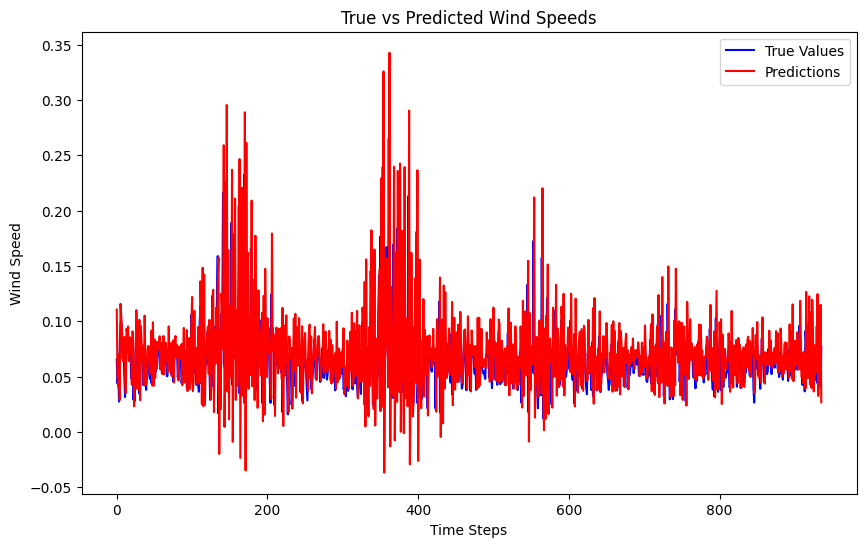

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

event_num = 1

train_df = pd.read_csv("./data/training_data.csv")
# for if we want to only analyze GANopolis
train_df = train_df[train_df["city"] == "GANopolis"] 

test_df = pd.read_csv(f"./data/event_{event_num}.csv")
                      
# Define the CITIES dictionary
CITIES = [
    dict(name="Sparseville", x=63, y=35),
    dict(name="Tensorburg", x=214, y=378),
    dict(name="Bayes Bay", x=160, y=262),
    dict(name="ReLU Ridge", x=413, y=23),
    dict(name="GANopolis", x=318, y=132),
    dict(name="Gradient Grove", x=468, y=158),
    dict(name="Offshore A", x=502, y=356),
    dict(name="Offshore B", x=660, y=184),
]

# Convert the CITIES list to a DataFrame for easy lookup
cities_df = pd.DataFrame(CITIES)

# Merge the 'city' column from train_df and test_df with the x and y values
train_df = train_df.merge(cities_df[['name', 'x', 'y']], left_on='city', right_on='name', how='left')
test_df = test_df.merge(cities_df[['name', 'x', 'y']], left_on='city', right_on='name', how='left')

# Calculate wind direction in radians
wind_dir_rad = np.arctan2(train_df['velocity_y'], train_df['velocity_x'])
wind_dir_deg = np.degrees(wind_dir_rad)

# Convert radians to degrees and normalize to [0, 360)
train_df['wind_dir_deg'] = np.degrees(wind_dir_rad) % 360

# Remove the velocity_x and velocity_y columns 
train_df.drop(columns=['velocity_x', 'velocity_y', 'city', 'name', 'damage', 'hour', 'day'], inplace=True)

# Do the same thing for the test 
wind_dir_rad = np.arctan2(test_df['velocity_y'], test_df['velocity_x'])
wind_dir_deg = np.degrees(wind_dir_rad)
test_df['wind_dir_deg'] = np.degrees(wind_dir_rad) % 360
test_df.drop(columns=['velocity_x', 'velocity_y', 'city', 'name', 'damage', 'hour', 'day'], inplace=True)

# Check the pre-processed results
print(train_df)
print(test_df)

# --------- Now implement the actual model ---------

# Select the 'wind speed' column as the target variable
windspeed = train_df['windspeed'].values.reshape(-1, 1)

# Normalize the data to the range [0, 1] for better performance with LSTMs
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(windspeed)

# --------- Do the same thing for the test_df --------- 

# Select the 'wind speed' column as the target variable
windspeed = test_df['windspeed'].values.reshape(-1, 1)

# Normalize the data to the range [0, 1] for better performance with LSTMs
test_data = scaler.fit_transform(windspeed)


"""
Converts a time series into sequences of input-output pairs for LSTM training.

Parameters:
    - data: The normalized time series data.
    - look_back: Number of previous time steps to use as input features.
    
Returns:
    - X: Input features (shape: [samples, look_back, 1]).
    - y: Target values (shape: [samples, 1]).
"""

def create_sequences(data, look_back=5):

    X, y = [], []
    
    for i in range(len(data) - look_back):
        # Extract the sequence of 'look_back' steps as input
        X.append(data[i:i + look_back])
        # The target is the next step after the sequence
        y.append(data[i + look_back])
    
    return np.array(X), np.array(y)


"""
Builds an LSTM model and trains it on the provided training data.

Parameters:
    - train_X: Input features for training.
    - train_y: Target values for training.
    - look_back: Number of time steps in each input sequence.
    
Returns:
    - model: The trained LSTM model.
"""
def build_and_train_lstm(train_X, train_y, look_back):

    # Initialize a sequential model
    model = Sequential()
    
    # Add an LSTM layer with 50 units (neurons) and input shape based on `look_back`
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    
    # Add a Dense layer to output a single value (regression task)
    model.add(Dense(1))
    
    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model for 50 epochs with batch size of 32
    model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=2)
    
    return model


"""
Evaluates the model on test data and makes predictions.

Parameters:
    - model: The trained LSTM model.
    - test_X: Input features for testing.
    - test_y: Target values for testing.
    - scaler: Scaler used to normalize the data (for inverse transformation).
    
Returns:
    - predictions: Predicted values (in original scale).
    - true_values: Actual values (in original scale).
    - rmse: Root Mean Squared Error of predictions.
"""
def evaluate_and_predict(model, test_X, test_y, scaler):
    # Make predictions using the LSTM model
    predictions = model.predict(test_X)
    
    # Invert scaling to get predictions in original scale
    predictions = scaler.inverse_transform(predictions)
    
    # Invert scaling for true values as well
    true_values = scaler.inverse_transform(test_y)
    
    # Calculate RMSE between predictions and true values
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    print(f"Test RMSE: {rmse}")
    
    return predictions, true_values, rmse


"""
Plots the true values vs. predicted values for visualization.

Parameters:
    - true_values: Actual target values from the test set.
    - predictions: Predicted values from the LSTM model.
"""
def plot_predictions(true_values, predictions):
    plt.figure(figsize=(10, 6))
    
    plt.plot(true_values, label='True Values', color='blue')
    plt.plot(predictions, label='Predictions', color='red')
    
    plt.title('True vs Predicted Wind Speeds')
    plt.xlabel('Time Steps')
    plt.ylabel('Wind Speed')
    
    plt.legend()

"""
Plots the true values vs. predicted values for visualization.

Parameters:
    - true_values: Actual target values from the test set.
    - predictions: Predicted values from the LSTM model.
"""
def plot_predictions(true_values, predictions):
    plt.figure(figsize=(10, 6))
    
    plt.plot(true_values, label='True Values', color='blue')
    plt.plot(predictions, label='Predictions', color='red')
    
    plt.title('True vs Predicted Wind Speeds')
    plt.xlabel('Time Steps')
    plt.ylabel('Wind Speed')
    
    plt.legend()

look_back = 24  # Number of previous time steps to use as input (e.g., 24 hours)
# Extract the windspeed column for train and test data
train_windspeed = train_df['windspeed'].values.reshape(-1, 1)
test_windspeed = test_df['windspeed'].values.reshape(-1, 1)

# Now, create sequences for both training and testing data
train_X, train_y = create_sequences(train_windspeed, look_back)
test_X, test_y = create_sequences(test_windspeed, look_back)


# Reshape data for LSTM (samples, time steps, features)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

model = build_and_train_lstm(train_X, train_y, look_back)

predictions, true_values, rmse = evaluate_and_predict(model, test_X, test_y, scaler)

plot_predictions(true_values, predictions)